# tif-forestobservatory2glm-overheadlines

TIF Image to Vegetation Impacts on Overhead Lines converter.

In [28]:
import ipyplot
ipyplot.plot_images(["MarinCounty-Vegetation-CanopyCover-2020-Summer-00010m.tiff"],img_width=500)

In [113]:
from PIL import Image
import IPython.display as dsp
import numpy as np
from scipy.interpolate import interp1d

res = 10 # TIFF resolution in meters
dd = res*39/12 # image resolution in feet
box = {"N":38.317511, "S":37.816952, "E":-122.372121, "W":-123.024393}
print('size:',data.shape)

def get_values(specs,p0,p1):
    img = Image.open("MarinCounty-Vegetation-CanopyCover-2020-Summer-00010m.tiff")
    data = numpy.array(img)
    x0 = int((p0["lon"]-box["W"])/(box["E"]-box["W"])*data.shape[0])
    y0 = int((p0["lat"]-box["N"])/(box["S"]-box["N"])*data.shape[1])
    x1 = int((p1["lon"]-box["W"])/(box["E"]-box["W"])*data.shape[0])
    y1 = int((p1["lat"]-box["N"])/(box["S"]-box["N"])*data.shape[1])
    dx = x1-x0
    dy = y1-y0
    s = 0.0
    n = 0
    zz = []
    tt = []
    if abs(dx) > abs(dy): # iterate over x
        y = y0
        r = dy/dx
        for x in range(x0,x1+1,np.sign(dx)):
            zz.append(data[int(x),int(y)])
            tt.append(np.sqrt((x0-x)*(x0-x)+(y0-y)*(y0-y))*dd)
            y += r
    else: # iterate over y
        x = x0
        r = dx/dy
        for y in range(y0,y1+1,np.sign(dy)):
            zz.append(data[int(x),int(y)])
            tt.append(np.sqrt((x0-x)*(x0-x)+(y0-y)*(y0-y))*dd)
            x += r
    d = round(np.sqrt(dx*dx+dy*dy)*dd) # distance in feet
    zz = np.array(zz)
    t = np.array(tt)
    z = list(map(lambda x:float(x/res/res),list(map(interp1d(t,zz),np.arange(tt[0],tt[-1],1.0)))))
    return {
        "from" : p0,
        "to" :p1,
        "min":zz.min(),
        "max":zz.max(),
        "avg":np.round(zz.mean(),1),
        "std":np.round(zz.std(),1),
        "len":d,
        "t" : np.arange(tt[0],tt[-1],1.0),
        "z": np.array(z),
    }
result = get_values("MarinCounty-Vegetation-CanopyCover-2020-Summer-00010m.tiff",{"lat":38.131435, "lon":-122.740464},{"lat":38.110846, "lon":-122.724984})

size: (5612, 5890)


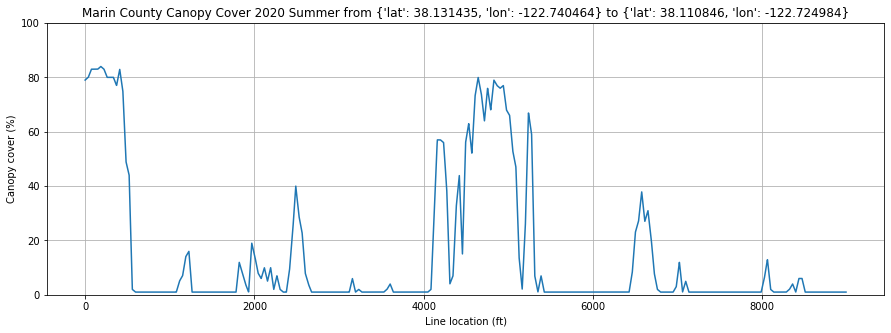

In [121]:
import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,5))
plt.plot(result["t"],result["z"]*100)
plt.xlabel('Line location (ft)')
plt.ylabel('Canopy cover (%)')
plt.ylim([0,100])
plt.grid()
plt.title(f"Marin County Canopy Cover 2020 Summer from {result['from']} to {result['to']}")
plt.show()